In [2]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

In [3]:
df = pd.read_csv('../data/clean_train.csv')

In [4]:
#some datetime manipulations
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

Text(0.5, 1.0, 'Number of Rides over the Year')

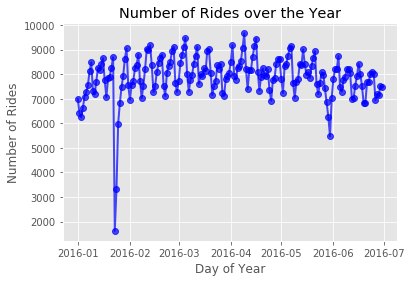

In [5]:
#plotting number of rides over the course of January to June

plt.plot(df.groupby('date').count()['id'], 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Year')

Create the time series dataframe

In [6]:
count =  df.groupby('date').count()['id']
series = pd.DataFrame(({'day': count.index, 'count': count.values})).set_index('day')
series = series[31:]
series.head()

,count
day,
2016-02-01,6962
2016-02-02,7564
2016-02-03,7721
2016-02-04,8235
2016-02-05,8394


In [8]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [9]:
# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

**Preprocessing the Data**

LSTMs are sensitive to the scale of the input data, especially when the activation function is either a sigmoid (default) or tanh function. We use sklearn.preprocessing library's MinMaxScaler function, such that all of the values in the dataset are rescaled into the ranges of 0 to 1. This is called normalizing.

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series)

We will do an 90/10 train-test split (for to see how this compares to the weekly detrended sarimax model)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

135 16


The create_dataset function below looks at our dataset, and creates a new dataframe of two columns containing the present value and the shifted value as previously explained. The lookback parameter describes the "lag" time of the shifted column

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Basic Neural Network

2 layer network with 50 neurons each, activation function is ReLu

In [14]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(testX.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(testX.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(trainX, trainY, batch_size=16, epochs=20, verbose=1)

W0714 15:33:59.954964  8752 deprecation_wrapper.py:119] From C:\Users\Justin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0714 15:33:59.955961  8752 deprecation_wrapper.py:119] From C:\Users\Justin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0714 15:33:59.998882  8752 deprecation_wrapper.py:119] From C:\Users\Justin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 15:34:00.001876  8752 deprecation_wrapper.py:119] From C:\Users\Justin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 15:34:00.005869  8

Epoch 1/20
133/133 [==============================] - 0s 2ms/step - loss: 0.5983
Epoch 2/20
133/133 [==============================] - 0s 83us/step - loss: 0.1548
Epoch 3/20
133/133 [==============================] - 0s 71us/step - loss: 0.0345
Epoch 4/20
133/133 [==============================] - 0s 68us/step - loss: 0.0216
Epoch 5/20
133/133 [==============================] - 0s 79us/step - loss: 0.0248
Epoch 6/20
133/133 [==============================] - 0s 79us/step - loss: 0.0228
Epoch 7/20
133/133 [==============================] - 0s 60us/step - loss: 0.0205
Epoch 8/20
133/133 [==============================] - 0s 75us/step - loss: 0.0199
Epoch 9/20
133/133 [==============================] - 0s 79us/step - loss: 0.0199
Epoch 10/20
133/133 [==============================] - 0s 64us/step - loss: 0.0198
Epoch 11/20
133/133 [==============================] - 0s 79us/step - loss: 0.0198
Epoch 12/20
133/133 [==============================] - 0s 68us/step - loss: 0.0197
Epoch 13/20
13

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 585.37 RMSE
Test Score: 448.86 RMSE


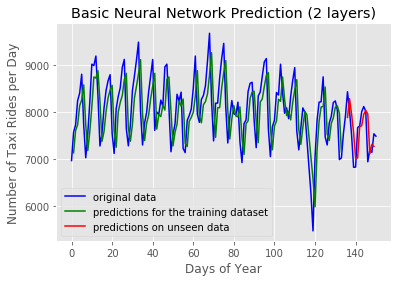

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#shfiting the testing dataset back
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color = 'blue', label = 'original data')
plt.plot(trainPredictPlot, color = 'green', label = 'predictions for the training dataset')
plt.plot(testPredictPlot, color= 'red', label = 'predictions on unseen data')
plt.xlabel('Days of Year')
plt.ylabel('Number of Taxi Rides per Day')
plt.title('Basic Neural Network Prediction (2 layers)')
plt.legend()
plt.show()

In sample train RMSE of 585, and out of sample test RMSE of 448 makes this simple two layer neural network with ReLu activation function the best predictive model above both the LSTM and the SARIMAX models.

# LSTM for Regression

Long Short Term Memory networks are a type of recurrent neural network that is trained through back propagation and overcomes the vanishing gradient problem. The recurrent neural network makes use of memory cells and the output of the previous time period values to make predictions of the future. 

Instead of neurons LSTM networks have memory blocks that are connected through layers. A block contains gates that manage the block's stae and output. A block operates on an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional. 

There are three types of gates in each unit:

- Forget Gate: decides what information to throw away from the block
- Input Gate: decides which values from the input to update the memory state
- Output Gate: decides what to output based on input and the memory of the block

Each unit is like a mini state machine where the gates of the units have weights that are learned during the training procedure.

Phrasing the data frame as a regression problem, we can phrase the question as given the number of rides these past couple months, what will be the number of taxi rides in the next couple of days?

We convert the single column of number of taxi rides into two columns, one for the value of count of taxi rides of the day, and the second column containing the number of taxi rides for the day afterwards (to be predicted)

Credit goes to https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [17]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series)
# split into train and test sets
train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

135 16


The LSTM network expects the input data to have an array structure of [samples, time steps, features]. Below, we use the np.reshape function to convert our training datasets into the above formmat. We use the time step of 1. 

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

The network has a visible layer with 1 input, a hidden layer with 50 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 40 epochs and a batch size of 1 is used.

In [19]:
# create and fit the LSTM network
K.clear_session()
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

W0714 15:34:16.224132  8752 deprecation.py:323] From C:\Users\Justin\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
 - 1s - loss: 0.1312
Epoch 2/20
 - 0s - loss: 0.0193
Epoch 3/20
 - 0s - loss: 0.0190
Epoch 4/20
 - 0s - loss: 0.0191
Epoch 5/20
 - 0s - loss: 0.0187
Epoch 6/20
 - 0s - loss: 0.0187
Epoch 7/20
 - 0s - loss: 0.0186
Epoch 8/20
 - 0s - loss: 0.0184
Epoch 9/20
 - 0s - loss: 0.0188
Epoch 10/20
 - 0s - loss: 0.0187
Epoch 11/20
 - 0s - loss: 0.0188
Epoch 12/20
 - 0s - loss: 0.0184
Epoch 13/20
 - 0s - loss: 0.0192
Epoch 14/20
 - 0s - loss: 0.0184
Epoch 15/20
 - 0s - loss: 0.0189
Epoch 16/20
 - 0s - loss: 0.0186
Epoch 17/20
 - 0s - loss: 0.0183
Epoch 18/20
 - 0s - loss: 0.0185
Epoch 19/20
 - 0s - loss: 0.0188
Epoch 20/20
 - 0s - loss: 0.0188


Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (number of taxi rides per day).

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 565.16 RMSE
Test Score: 527.94 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

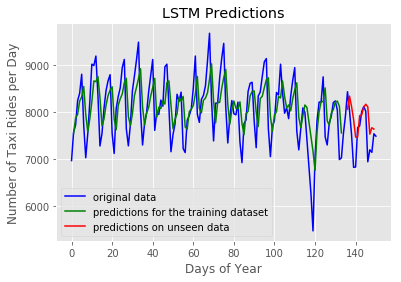

In [22]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#shfiting the testing dataset back
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color = 'blue', label = 'original data')
plt.plot(trainPredictPlot, color = 'green', label = 'predictions for the training dataset')
plt.plot(testPredictPlot, color= 'red', label = 'predictions on unseen data')
plt.xlabel('Days of Year')
plt.ylabel('Number of Taxi Rides per Day')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

We can see that in this case, the simple neural network with 2 layers actually worked better than the LTSM at forecasting and modeling in terms of out of sample test RMSE.

The SARIMAX model also performed better than the LSTM model in terms of both in sample and out of sample RMSE. 